In [1]:
from tensorflow.python import keras
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Dense
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas
from tensorflow.keras import utils
import cv2
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas

/home/entilza/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/entilza/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/entilza/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/entilza/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:5

In [2]:
# Каталог с данными для обучения
train_dir = './bigpic/transformed/train'
# Каталог с данными для проверки
val_dir = './bigpic/transformed/val'
# Каталог с данными для тестирования
test_dir = './bigpic/transformed/test'
# Размеры изображения
img_width, img_height = 100, 100
# Размерность тензора на основе изображения для входных данных в нейронную сеть
# backend Tensorflow, channels_last
input_shape = (img_width, img_height, 3)
# Количество эпох
epochs = 30
# Размер мини-выборки
batch_size = 28
# Количество изображений для обучения
nb_train_samples = 656
# Количество изображений для проверки
nb_validation_samples = 83
# Количество изображений для тестирования
nb_test_samples = 83

In [10]:
classes = ['круассан','полки','пончик', 'завиток',]

In [4]:
vgg16_net = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
vgg16_net.trainable = False
#vgg16_net.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [5]:
model = Sequential()



#model.add(Conv2D(32, (3, 3), input_shape=input_shape))
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(Conv2D(32, (3, 3)))
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(Conv2D(64, (3, 3)))
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(vgg16_net)
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation('sigmoid'))

In [17]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

In [11]:
def SaltAndPaper (im, probability):
    # probability of the noise 
    out = np.random.randint(0,probability, im.shape)
    out = out + im
    out[out>255]=255
    #out = out.astype(np.uint8)
    return out

def ColorBalance(im, probability):
    colorB = np.random.random() * (1-probability) + probability
    colorG = np.random.random() * (1-probability) + probability
    colorR = np.random.random() * (1-probability) + probability
    out = im.copy()
    out[:,:,0] = im[:,:, 0] * colorB
    out[:,:,1] = im[:,:, 1] * colorG
    out[:,:,2] = im[:,:, 2] * colorR
    return out

def BoxFilter(im, ksize):
    BoxFilter_image = cv2.boxFilter(im, 0, (ksize,ksize))
    #BoxFilter_image
    return BoxFilter_image

def trah(img):
    #img = ColorBalance(img, 0.5)
    #img = BoxFilter(img, 3)
    img = SaltAndPaper(img, 20)
    img = img.astype(np.float32)
    return img

In [12]:
datagen = ImageDataGenerator(rescale=1./255., 
                             rotation_range=45,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.2,
                             shear_range=0.2,
                             brightness_range=[0.5, 1.0],
                             channel_shift_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True,
                             fill_mode="nearest",
                             preprocessing_function=trah
                            )

In [74]:
img = image.load_img("./bigpic/transformed/train/cruassan.1.jpg")
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
imageGen = datagen.flow(img, batch_size=1, save_to_dir="output", save_prefix="output", save_format="jpg")
total = 0
for img in imageGen:
    # increment our counter
    total += 1
    if total > 10:
        break
print(total)

11


In [13]:
test_df = pandas.read_csv("./bigpic/transformed/test.csv")
train_df = pandas.read_csv("./bigpic/transformed/train.csv")
val_df = pandas.read_csv("./bigpic/transformed/val.csv")

train_generator = datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=None,
        x_col="filename",
        y_col="label",
        subset="training",
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

val_generator = datagen.flow_from_dataframe(
        dataframe=val_df,
        directory=None,
        x_col="filename",
        y_col="label",
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical')

test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=None,
        x_col="filename",
        y_col="label",
        target_size=(img_width, img_height),
        batch_size=1,
        class_mode='categorical')


Found 656 validated image filenames belonging to 4 classes.
Found 83 validated image filenames belonging to 4 classes.
Found 83 validated image filenames belonging to 4 classes.


In [9]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=nb_validation_samples // batch_size)


Epoch 1/30
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
8/8 [==============================] - 37s 5s/step - loss: 1.4898 - acc: 0.2634 - val_loss: 1.4351 - val_acc: 0.1786
Epoch 2/30
8/8 [==============================] - 34s 4s/step - loss: 1.5038 - acc: 0.2946 - val_loss: 1.3692 - val_acc: 0.3214
Epoch 3/30
8/8 [==============================] - 34s 4s/step - loss: 1.4824 - acc: 0.2321 - val_loss: 1.3520 - val_acc: 0.4286
Epoch 4/30
8/8 [==============================] - 34s 4s/step - loss: 1.4648 - acc: 0.2589 - val_loss: 1.4054 - val_acc: 0.3571
Epoch 5/30
8/8 [==============================] - 34s 4s/step - loss: 1.5818 - acc: 0.2188 - val_loss: 1.3424 - val_acc: 0.3571
Epoch 6/30
8/8 [==============================] - 34s 4s/step - loss: 1.5306 - acc: 0.2500 - val_loss: 1.3974 - val_acc: 0.3214
Epoch 7/30
8/8 [==============================] - 34s 4s/step - loss: 1.4986 - acc: 0.2768 - val_loss: 1.4225 - val_acc: 0.3214
Epoch 8/30

In [76]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1179904   
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0

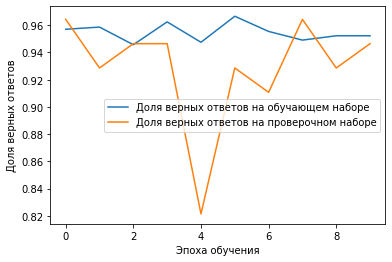

In [16]:
plt.plot(history.history['acc'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_acc'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [12]:
scores = model.evaluate_generator(test_generator, nb_test_samples)
print("Точность на тестовых данных: %.2f%%" % (scores[1]*100))

Точность на тестовых данных: 42.86%


In [77]:
vgg16_net.trainable = True
trainable = False
for layer in vgg16_net.layers:
    if layer.name == 'block3_conv1':
        trainable = True
    layer.trainable = trainable

In [78]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Сохраняем сеть на каждой эпохе
# {epoch:02d} - номер эпохи
# {val_acc:.4f} - значение доли верных значений на проверочном наборе данных
callbacks = [ModelCheckpoint('saveModelWeightStep/{epoch:02d}-{acc:.4f}-{val_acc:.4f}.hdf5')]
# Сохраняем только лучший вариант сети
#callbacks = [ModelCheckpoint('save/mnist-dense.hdf5', monitor='val_loss', save_best_only=True)]

In [79]:
model = keras.models.load_model('4classbigpic.h5')

In [80]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.00001),
              metrics=['accuracy'])

In [81]:
class_weights_dict = {0:1 , 1:1, 2:1.26, 3:2.7}

In [82]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=30,
    class_weight = class_weights_dict,
    validation_data=val_generator,
    validation_steps=nb_validation_samples // batch_size, 
    callbacks=callbacks)

Epoch 1/30
23/23 [==============================] - 259s 11s/step - loss: 0.2693 - acc: 0.9411 - val_loss: 0.3130 - val_acc: 0.9107
Epoch 2/30
23/23 [==============================] - 257s 11s/step - loss: 0.2299 - acc: 0.9459 - val_loss: 0.0986 - val_acc: 0.9643
Epoch 3/30
23/23 [==============================] - 247s 11s/step - loss: 0.1912 - acc: 0.9538 - val_loss: 0.2400 - val_acc: 0.9286
Epoch 4/30
23/23 [==============================] - 248s 11s/step - loss: 0.1512 - acc: 0.9618 - val_loss: 0.5786 - val_acc: 0.8393
Epoch 5/30
23/23 [==============================] - 255s 11s/step - loss: 0.3249 - acc: 0.9255 - val_loss: 0.2528 - val_acc: 0.9286
Epoch 6/30
23/23 [==============================] - 243s 11s/step - loss: 0.2559 - acc: 0.9412 - val_loss: 0.3012 - val_acc: 0.9107
Epoch 7/30
23/23 [==============================] - 248s 11s/step - loss: 0.3422 - acc: 0.9283 - val_loss: 0.1483 - val_acc: 0.9643
Epoch 8/30
23/23 [==============================] - 255s 11s/step - loss: 0.

In [83]:
scores = model.evaluate_generator(test_generator, nb_test_samples)
print("Точность на тестовых данных: %.2f%%" % (scores[1]*100))

Точность на тестовых данных: 95.18%


In [61]:
#model.save('4classcopy.h5')

In [ ]:
spisokModels = pandas.read_csv("modelslist.csv")
for m in range(len(spisokModels)):
    print(spisokModels.iloc[m,0])
    model = keras.models.load_model(spisokModels.iloc[m,0])
    scores = model.evaluate_generator(test_generator, nb_test_samples)
    #print(m)
    print("Точность на тестовых данных: %.2f%%" % (scores[1]*100))

./saveModelWeightStep/30-0.9554-0.9643.hdf5
0
Точность на тестовых данных: 95.18%
./saveModelWeightStep/04-0.9379-0.9821.hdf5
1
Точность на тестовых данных: 93.98%
./saveModelWeightStep/27-0.9395-0.9464.hdf5
2
Точность на тестовых данных: 93.98%
./saveModelWeightStep/10-0.9522-0.9464.hdf5
3
Точность на тестовых данных: 96.39%
./saveModelWeightStep/07-0.9554-0.9107.hdf5
4
Точность на тестовых данных: 93.98%
./saveModelWeightStep/06-0.9045-0.8214.hdf5
5
Точность на тестовых данных: 89.16%
./saveModelWeightStep/16-0.9411-0.8929.hdf5
6
Точность на тестовых данных: 85.54%
./saveModelWeightStep/07-0.8742-0.8214.hdf5
7
Точность на тестовых данных: 91.57%
./saveModelWeightStep/04-0.9624-0.9464.hdf5
8
Точность на тестовых данных: 93.98%
./saveModelWeightStep/08-0.9172-0.8393.hdf5
9
Точность на тестовых данных: 89.16%
./saveModelWeightStep/08-0.9490-0.9643.hdf5
10
Точность на тестовых данных: 96.39%
./saveModelWeightStep/12-0.9379-0.9464.hdf5
11
Точность на тестовых данных: 93.98%
./saveModelWei

In [84]:
#model.save('4classbigpic.h5')

In [43]:
#print("Сохраняем сеть")
# Сохраняем сеть для последующего использования
# Генерируем описание модели в формате json
#model_json = model.to_json()
#json_file = open("4class.json", "w")
# Записываем архитектуру сети в файл
#json_file.write(model_json)
#json_file.close()
# Записываем данные о весах в файл
#model.save_weights("mnist_model.h5")
#print("Сохранение сети завершено")

In [20]:
#model = keras.models.load_model('75x75.h5')

In [36]:
# создаем csv-файл со списком тестовых картинок и отображаем результаты теста по каждой
spisoktest = pandas.read_csv("test.csv")
for k in range(len(spisoktest)):
    print(spisoktest.iloc[k,0])
    im = spisoktest.iloc[k,0]
    img = image.load_img(im, target_size=(img_width, img_height))
    # Преобразуем картинку в массив
    x = image.img_to_array(img)
    x = x.reshape(1, x.shape[0],x.shape[1],x.shape[2])
    # Нормализуем изображение
    x /= 255
    prediction = model.predict(x)
    prediction
    prediction = np.argmax(prediction)
    print("Номер класса:", prediction)
    print("Название класса:", classes[prediction])
        

/home/entilza/Chris/NN/test/cruassan/cruassan.63.jpg
Номер класса: 0
Название класса: круассан
/home/entilza/Chris/NN/test/cruassan/cruassan.64.jpg
Номер класса: 0
Название класса: круассан
/home/entilza/Chris/NN/test/cruassan/cruassan.65.jpg
Номер класса: 0
Название класса: круассан
/home/entilza/Chris/NN/test/cruassan/cruassan.66.jpg
Номер класса: 0
Название класса: круассан
/home/entilza/Chris/NN/test/cruassan/cruassan.67.jpg
Номер класса: 0
Название класса: круассан
/home/entilza/Chris/NN/test/cruassan/cruassan.68.jpg
Номер класса: 0
Название класса: круассан
/home/entilza/Chris/NN/test/cruassan/cruassan.69.jpg
Номер класса: 0
Название класса: круассан
/home/entilza/Chris/NN/test/polki/polki.63.jpg
Номер класса: 1
Название класса: полки
/home/entilza/Chris/NN/test/polki/polki.64.jpg
Номер класса: 1
Название класса: полки
/home/entilza/Chris/NN/test/polki/polki.65.jpg
Номер класса: 1
Название класса: полки
/home/entilza/Chris/NN/test/polki/polki.66.jpg
Номер класса: 1
Название класс